# OpenCredit: End-to-End Explainable Credit Scoring System
## Phase 1: Data Discovery & Preprocessing

**Objective:**
This notebook aims to perform initial Exploratory Data Analysis (EDA) and data cleaning on the raw credit dataset. We will transform "dirty" financial records into a structured format suitable for Machine Learning models.

**Key Tasks:**
1. Load the raw dataset and inspect data types.
2. Drop irrelevant features (PII and noise).
3. Clean and convert "object" type numerical columns into proper floating-point numbers.
4. Handle missing values and outliers.

In [3]:
import pandas as pd
import numpy as np

# Configuration to view all columns in the dataframe
pd.set_option('display.max_columns', None)

print("Libraries imported successfully.")

Libraries imported successfully.


We import pandas for data manipulation and numpy for numerical operations. Setting max_columns to None ensures we can inspect every feature in the dataset.

In [2]:
import os
print("Şu anki klasörüm:", os.getcwd())
print("İçindeki dosyalar:", os.listdir())

Şu anki klasörüm: C:\Users\LENOVO\open-credit-project
İçindeki dosyalar: ['.ipynb_checkpoints', '01_data_discovery.ipynb', 'data', 'models', 'notebooks', 'src', 'venv']


### 1. Data Loading
We load the raw training data from the local `data/` directory.

In [4]:
# Loading the dataset (Path adjusted to root directory)
df = pd.read_csv("data/train.csv")

# Quick look at the first 5 rows
df.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24000\2199570846.py:2: DtypeWarning: Columns (0: Monthly_Balance) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


**read_csv** loads the file into a DataFrame. The head() function allows us to see the initial records and identify obvious data quality issues (like underscores in numbers).

### 2. Data Inspection
Checking the data types and the presence of null values across all features.

In [5]:
# Summary of the dataframe structure
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  str    
 1   Customer_ID               100000 non-null  str    
 2   Month                     100000 non-null  str    
 3   Name                      90015 non-null   str    
 4   Age                       100000 non-null  str    
 5   SSN                       100000 non-null  str    
 6   Occupation                100000 non-null  str    
 7   Annual_Income             100000 non-null  str    
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  str    
 13  Type_of_Loan              88592 non-null   str    
 14  

**info()** reveals that several numerical columns like Age and Annual_Income are stored as object (strings). This is due to special characters within the data that must be cleaned.

### 3. Data Cleaning & Feature Selection
In this step, we drop identifiers that carry no predictive power (noise) and fix corrupted numerical columns using Regular Expressions (Regex).

In [6]:
# 1. Dropping non-predictive features and PII (Personally Identifiable Information)
cols_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Occupation']
df_cleaned = df.drop(columns=cols_to_drop)

# 2. Defining columns that should be numerical but contain string characters
# Example: "23_" -> 23.0 or "9500.20_" -> 9500.20
cols_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
               'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

for col in cols_to_fix:
    # Extract only numbers and decimals using Regex, then convert to float
    df_cleaned[col] = df_cleaned[col].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# Verify the changes
print("Updated Data Types:")
print(df_cleaned.dtypes.head(15))
df_cleaned.head()

Updated Data Types:
Age                         float64
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                      str
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age              str
dtype: object


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,19114.12,1824.843333,3,4,3,4.0,3,7.0,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23.0,19114.12,NaN,3,4,3,4.0,-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,500.0,19114.12,NaN,3,4,3,4.0,3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,23.0,19114.12,NaN,3,4,3,4.0,5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,23.0,19114.12,1824.843333,3,4,3,4.0,6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


**Drop:** We remove columns like Name and SSN because they don't help in predicting credit risk.

**Regex Extraction:** Financial data often contains "noise" (e.g., trailing underscores). We use str.extract with a regex pattern (\d+\.?\d*) to pick only the valid numeric part and cast it to a float.

### 4. Advanced Logical Consistency & Outlier Handling
Financial datasets often contain human or system entry errors. In this section, we "clip" or filter impossible values (e.g., negative ages or having 1000 bank accounts) to prevent the model from learning from noise.

In [7]:
# Create a copy to track changes
df_consistent = df_cleaned.copy()

# 1. Fixing 'Age': Clipping between 18 and 80 (standard banking range)
df_consistent['Age'] = df_consistent['Age'].clip(lower=18, upper=80)

# 2. Fixing 'Num_Bank_Accounts': Values above 20 are likely errors
df_consistent['Num_Bank_Accounts'] = df_consistent['Num_Bank_Accounts'].clip(lower=0, upper=20)

# 3. Fixing 'Num_Credit_Card': Clipping at 15
df_consistent['Num_Credit_Card'] = df_consistent['Num_Credit_Card'].clip(lower=0, upper=15)

# 4. Fixing 'Interest_Rate': Capping at 40% (high but realistic for some loans)
df_consistent['Interest_Rate'] = df_consistent['Interest_Rate'].clip(lower=0, upper=40)

# 5. Fixing 'Num_of_Loan': Values above 20 are treated as outliers
df_consistent['Num_of_Loan'] = df_consistent['Num_of_Loan'].clip(lower=0, upper=20)

print("Logical consistency checks and outlier clipping completed.")

Logical consistency checks and outlier clipping completed.


### 5. Handling Missing Values
We apply a median imputation strategy for numerical columns and a mode strategy for categorical columns to ensure the dataset is complete before modeling.

In [8]:
# Filling numerical missing values with median
numeric_cols = df_consistent.select_dtypes(include=[np.number]).columns
df_consistent[numeric_cols] = df_consistent[numeric_cols].fillna(df_consistent[numeric_cols].median())

# Filling categorical missing values with the most frequent value (mode)
categorical_cols = df_consistent.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_consistent[col] = df_consistent[col].fillna(df_consistent[col].mode()[0])

print("Total Missing Values After Imputation:", df_consistent.isnull().sum().sum())

Total Missing Values After Imputation: 0


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24000\2756396197.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_consistent.select_dtypes(include=['object']).columns


### 6. Strategic Feature Engineering
Instead of blindly generating hundreds of features, we focus on **Domain-Driven Ratios**. These features simulate how a bank evaluates a customer's repayment capacity.

- **Debt_to_Income**: High ratio indicates high risk.
- **Monthly_Invested_Ratio**: High ratio shows financial discipline.
- **Credit_Utilization**: Ratio of monthly balance to credit limit changes.

In [10]:
# 1. Debt to Annual Income Ratio
df_consistent['Debt_to_Income'] = df_consistent['Outstanding_Debt'] / (df_consistent['Annual_Income'] + 1)

# 2. Monthly Investment Ratio
df_consistent['Monthly_Invest_Ratio'] = df_consistent['Amount_invested_monthly'] / (df_consistent['Monthly_Inhand_Salary'] + 1)

# 3. Balance Utilization
df_consistent['Balance_to_Debt_Ratio'] = df_consistent['Monthly_Balance'] / (df_consistent['Outstanding_Debt'] + 1)

print("Engineered 3 high-impact financial features.")
df_consistent[['Debt_to_Income', 'Monthly_Invest_Ratio', 'Balance_to_Debt_Ratio']].head()

Engineered 3 high-impact financial features.


,Debt_to_Income,Monthly_Invest_Ratio,Balance_to_Debt_Ratio
0,0.042374,0.044043,0.385329
1,0.042374,0.038220,0.350969
2,0.042374,0.026399,0.408407
3,0.042374,0.064451,0.275532
4,0.042374,0.022685,0.421082


### 7. Target & Categorical Encoding
Final preparation: Mapping the target variable and encoding remaining categories for model compatibility.

In [11]:
# Encoding the Target Variable (Credit_Score)
target_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}
df_consistent['Credit_Score'] = df_consistent['Credit_Score'].map(target_mapping)

# Manual encoding for 'Credit_Mix' (Ordinal Importance)
mix_mapping = {'Bad': 0, 'Standard': 1, 'Good': 2}
df_consistent['Credit_Mix'] = df_consistent['Credit_Mix'].map(mix_mapping)

# Simple Label Encoding for 'Payment_of_Min_Amount'
df_consistent['Payment_of_Min_Amount'] = df_consistent['Payment_of_Min_Amount'].map({'No': 0, 'Yes': 1, 'NM': 0.5})

# Convert any remaining objects to categorical codes
for col in df_consistent.select_dtypes(include=['object']).columns:
    df_consistent[col] = df_consistent[col].astype('category').cat.codes

print("Final encoding and target mapping completed.")
df_consistent.info()

Final encoding and target mapping completed.
<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Annual_Income             100000 non-null  float64
 2   Monthly_Inhand_Salary     100000 non-null  float64
 3   Num_Bank_Accounts         100000 non-null  int64  
 4   Num_Credit_Card           100000 non-null  int64  
 5   Interest_Rate             100000 non-null  int64  
 6   Num_of_Loan               100000 non-null  float64
 7   Delay_from_due_date       100000 non-null  int64  
 8   Num_of_Delayed_Payment    100000 non-null  float64
 9   Changed_Credit_Limit      100000 non-null  float64
 10  Num_Credit_Inquiries      100000 non-null  float64
 11  Credit_Mix                79805 non-null   float64
 12  Outstanding_Debt          100000 non-null  float64
 13  Credit_Util

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24000\1318024517.py:13: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df_consistent.select_dtypes(include=['object']).columns:


### 9. Exploratory Data Analysis (Visualizations)
Before moving to modeling, we visualize the data to understand the relationships between features and our target variable 'Credit_Score'.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24000\2580455110.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_consistent, x='Credit_Score', palette='viridis')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24000\2580455110.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_consistent, x='Credit_Score', y='Debt_to_Income', palette='magma')


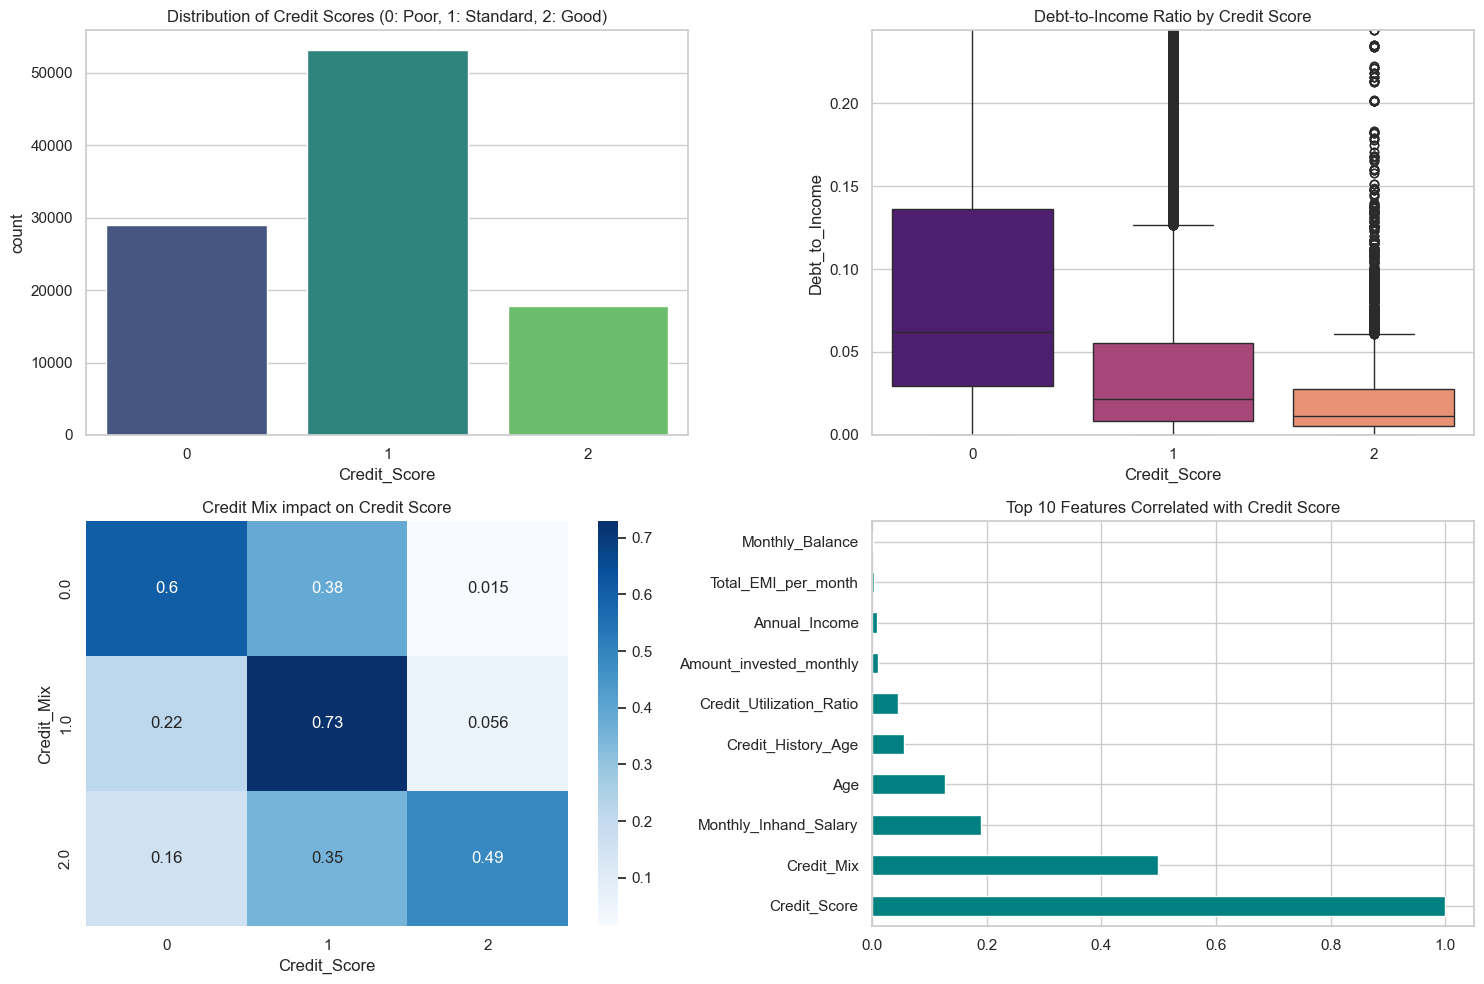

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# 1. Distribution of Target Variable
plt.subplot(2, 2, 1)
# df_final yerine df_consistent yazıyoruz
sns.countplot(data=df_consistent, x='Credit_Score', palette='viridis') 
plt.title('Distribution of Credit Scores (0: Poor, 1: Standard, 2: Good)')

# 2. Debt to Income Ratio vs Credit Score
plt.subplot(2, 2, 2)
sns.boxplot(data=df_consistent, x='Credit_Score', y='Debt_to_Income', palette='magma')
plt.title('Debt-to-Income Ratio by Credit Score')
plt.ylim(0, df_consistent['Debt_to_Income'].quantile(0.95)) 

# 3. Credit Mix vs Credit Score
plt.subplot(2, 2, 3)
sns.heatmap(pd.crosstab(df_consistent['Credit_Mix'], df_consistent['Credit_Score'], normalize='index'), 
            annot=True, cmap='Blues')
plt.title('Credit Mix impact on Credit Score')

# 4. Correlation Heatmap (Top Features)
plt.subplot(2, 2, 4)
top_corr = df_consistent.corr()['Credit_Score'].sort_values(ascending=False).head(10)
top_corr.plot(kind='barh', color='teal')
plt.title('Top 10 Features Correlated with Credit Score')

plt.tight_layout()
plt.show()

In [14]:
df_consistent.to_csv("data/cleaned_credit.csv", index=False)
print("Data saved successfully!")

Data saved successfully!
